## In this notebook i tried to improving my feature engineering techniques compared to my previous findings

In [2]:
import plotly
import plotly.express as px
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gc 
import pickle
from tqdm.auto import tqdm
import time
from joblib import Parallel, delayed
from sklearn.metrics import f1_score,confusion_matrix, precision_recall_fscore_support,classification_report,accuracy_score,log_loss
from sklearn.model_selection import train_test_split

In [3]:
# loading data into pandas dataframe
orders = pd.read_csv('orders.csv',dtype={'order_id':np.uint32,
                                                  'user_id' :np.uint32,
                                                  'order_number':'uint8',
                                                  'order_hour_of_day':'uint8',
                                                  'order_dow':'uint8',
                                                  'days_since_prior_order':'float16'})
dep = pd.read_csv('departments.csv', dtype={'department_id':'uint8',
                                                     'department': str})
aisles = pd.read_csv('aisles.csv', dtype={'aisle_id':'uint8',
                                                     'aisle': str})
products = pd.read_csv('products.csv', dtype={'aisle_id':'uint8',
                                                     'department_id':'uint8',
                                                     'product_name': str,
                                                     'product_id': np.uint16})
order_products_prior = pd.read_csv('order_products__prior.csv',
                                   dtype={'add_to_cart_order':'uint8',
                                          'reordered':'uint8',
                                          'order_id':np.uint32,
                                          'product_id':np.uint16})
order_products_train = pd.read_csv('order_products__train.csv',
                                   dtype={'add_to_cart_order':'uint8',
                                          'reordered':'uint8',
                                          'order_id':np.uint32,
                                          'product_id':np.uint16})

In [4]:
# Merging relational tables
# joining orders and order_products_prior table to get whole prior data table.
prior_data = orders.merge(order_products_prior, how='inner', on='order_id')

# sorting prior_data to get a more structured data so that we can analyse well.
prior_data.sort_values(['user_id','order_number','add_to_cart_order'],inplace=True, axis='index',ignore_index=True)
prior_data

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434484,2977660,206209,prior,13,1,12,7.0,14197,5,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0


In [5]:
prod_info = products.merge(dep,on='department_id').merge(aisles,on='aisle_id')
prod_info

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes
...,...,...,...,...,...,...
49683,22827,Organic Black Mission Figs,18,10,bulk,bulk dried fruits vegetables
49684,28655,Crystallized Ginger Chunks,18,10,bulk,bulk dried fruits vegetables
49685,30365,Vegetable Chips,18,10,bulk,bulk dried fruits vegetables
49686,38007,Naturally Sweet Plantain Chips,18,10,bulk,bulk dried fruits vegetables


In [6]:
# users and their prior order's products
users_prior_order_products = prior_data[['user_id','product_id']].drop_duplicates(ignore_index=True)
users_prior_order_products

,user_id,product_id
0,1,196
1,1,14084
2,1,12427
3,1,26088
4,1,26405
...,...,...
13307948,206209,39216
13307949,206209,38730
13307950,206209,31477
13307951,206209,6567


In [7]:
# users and their prior order's products and future_order_id
users = orders.loc[~orders.eval_set.str.contains('prior'),['user_id','order_id','eval_set']]
dataset = users_prior_order_products.merge(users,on='user_id',how='inner')
del users_prior_order_products
del users
dataset

,user_id,product_id,order_id,eval_set
0,1,196,1187899,train
1,1,14084,1187899,train
2,1,12427,1187899,train
3,1,26088,1187899,train
4,1,26405,1187899,train
...,...,...,...,...
13307948,206209,39216,272231,train
13307949,206209,38730,272231,train
13307950,206209,31477,272231,train
13307951,206209,6567,272231,train


In [8]:
dataset[dataset['eval_set']=='test']

,user_id,product_id,order_id,eval_set
120,3,9387,2774568,test
121,3,17668,2774568,test
122,3,15143,2774568,test
123,3,16797,2774568,test
124,3,39190,2774568,test
...,...,...,...,...
13307880,206208,18880,803273,test
13307881,206208,34282,803273,test
13307882,206208,21405,803273,test
13307883,206208,7632,803273,test


In [9]:
dataset = dataset.merge(order_products_train,on=['order_id','product_id'],how='left')
dataset.drop(columns=['add_to_cart_order'],inplace=True)
dataset.loc[(dataset['reordered'].isna()) & (dataset.eval_set.str.contains('train')),'reordered']=0
dataset

,user_id,product_id,order_id,eval_set,reordered
0,1,196,1187899,train,1.0
1,1,14084,1187899,train,0.0
2,1,12427,1187899,train,0.0
3,1,26088,1187899,train,1.0
4,1,26405,1187899,train,1.0
...,...,...,...,...,...
13307948,206209,39216,272231,train,1.0
13307949,206209,38730,272231,train,0.0
13307950,206209,31477,272231,train,0.0
13307951,206209,6567,272231,train,0.0


In [10]:
users_train = orders.loc[orders.eval_set.str.contains('train'),['user_id']]
users_train, users_cv = train_test_split(users_train,
                                         shuffle=True,
                                         test_size=0.3,
                                         random_state=31)
print(f'No. of train users = {len(users_train)}')
print(f'No. of cv users = {len(users_cv)}')

No. of train users = 91846
No. of cv users = 39363


In [11]:
users_cv['set']='cv'
users_cv.head()

,user_id,set
36594,2260,cv
77977,4752,cv
1084601,65324,cv
2067224,124271,cv
1676808,100656,cv


In [12]:
# adding cv to the eval_set for cv users
dataset = dataset.merge(users_cv,on='user_id',how='left')
dataset.loc[dataset['set']=='cv','eval_set']='cv'
dataset.drop(columns=['set'],inplace=True)
dataset

,user_id,product_id,order_id,eval_set,reordered
0,1,196,1187899,cv,1.0
1,1,14084,1187899,cv,0.0
2,1,12427,1187899,cv,0.0
3,1,26088,1187899,cv,1.0
4,1,26405,1187899,cv,1.0
...,...,...,...,...,...
13307948,206209,39216,272231,train,1.0
13307949,206209,38730,272231,train,0.0
13307950,206209,31477,272231,train,0.0
13307951,206209,6567,272231,train,0.0


In [13]:
dataset[dataset['eval_set']=='test'].reordered.unique()

array([nan])

In [14]:
print('No. of datapoints in each set:')
print('Train:'.ljust(12),len(dataset[dataset.eval_set=='train']))
print('Validation:'.ljust(12),len(dataset[dataset.eval_set=='cv']))
print('Test:'.ljust(12),len(dataset[dataset.eval_set=='test']))

No. of datapoints in each set:
Train:       5929287
Validation:  2545374
Test:        4833292


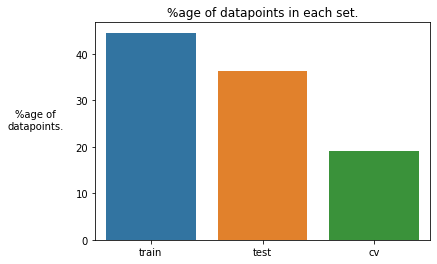

In [15]:
eval_set_percentage = dataset['eval_set'].value_counts(normalize=True)*100
sns.barplot(x=eval_set_percentage.index,y=eval_set_percentage,orient='v')
plt.ylabel('%age of\ndatapoints.',rotation=0,labelpad=40,)
plt.title('%age of datapoints in each set.');

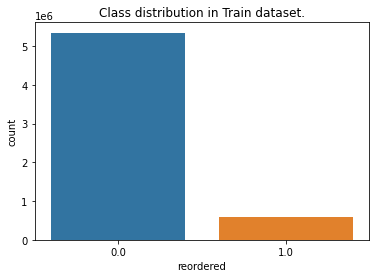

In [16]:
# class distribution cv
sns.countplot(data=dataset[dataset.eval_set=='train'],x='reordered')
plt.title('Class distribution in Train dataset.');

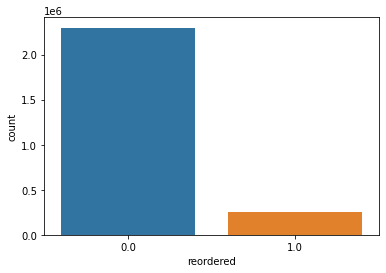

In [17]:
# class distribution in train
sns.countplot(data=dataset[dataset.eval_set=='cv'],x='reordered');

In [18]:
user_info = (
    prior_data.groupby('user_id')['reordered']
    .agg(['sum','count'])
    .rename(columns={'sum':'#reorders_u', 'count':'#purchases_u'})
    .reset_index()
)
user_info.head()

,user_id,#reorders_u,#purchases_u
0,1,41.0,59
1,2,93.0,195
2,3,55.0,88
3,4,1.0,18
4,5,14.0,37


In [19]:
user_info['#first_purchases_u'] = user_info['#purchases_u']-user_info['#reorders_u']
user_info['p(reorder|user)_u'] = user_info['#reorders_u']/user_info['#purchases_u']
user_info.head()

,user_id,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u
0,1,41.0,59,18.0,0.694915
1,2,93.0,195,102.0,0.476923
2,3,55.0,88,33.0,0.625000
3,4,1.0,18,17.0,0.055556
4,5,14.0,37,23.0,0.378378


In [20]:
user_purchases_per_order = (
    prior_data[prior_data.order_number!=1].groupby(['user_id','order_id'])['reordered']
    .agg(['sum','count'])
    .rename(columns={'sum':'#reorders_u', 'count':'#purchases_u'})
    .reset_index()
)
# not considered order_number=1 because reorders will be 0 for this order.
user_purchases_per_order.head()

,user_id,order_id,#reorders_u,#purchases_u
0,1,431534,5,8
1,1,473747,3,5
2,1,550135,5,5
3,1,2254736,5,5
4,1,2295261,6,6


In [21]:
user_purchases_per_order['#first_purchases_u'] = user_purchases_per_order['#purchases_u']-user_purchases_per_order['#reorders_u']
user_purchases_per_order['p(reorder|user,order)_u'] = user_purchases_per_order['#reorders_u']/user_purchases_per_order['#purchases_u']
user_purchases_per_order.head()

,user_id,order_id,#reorders_u,#purchases_u,#first_purchases_u,"p(reorder|user,order)_u"
0,1,431534,5,8,3,0.625
1,1,473747,3,5,2,0.600
2,1,550135,5,5,0,1.000
3,1,2254736,5,5,0,1.000
4,1,2295261,6,6,0,1.000


In [22]:
user_purchases_per_order.drop(columns=['order_id'],inplace=True)


In [23]:

user_purchases_per_order = (
    user_purchases_per_order
    .groupby('user_id')
    .agg(['mean','median','min','max'])
)
user_purchases_per_order

#reorders_u                #purchases_u                 \
               mean median min max         mean median min max   
user_id                                                          
1          4.555556    5.0   3   6     6.000000    6.0   4   9   
2          7.153846    9.0   0  14    14.000000   14.0   5  26   
3          5.000000    5.0   1   7     7.090909    6.0   5  11   
4          0.250000    0.0   0   1     3.500000    2.5   2   7   
5          4.666667    4.0   2   8     8.666667    9.0   5  12   
...             ...    ...  ..  ..          ...    ...  ..  ..   
206205     4.000000    4.0   2   6     7.500000    7.5   7   8   
206206     2.045455    2.0   0   6     4.257576    4.0   1  24   
206207     8.733333    8.0   1  15    13.266667   13.0   5  25   
206208     9.979167    9.0   2  26    13.854167   13.5   4  28   
206209     5.083333    4.0   1  14     9.666667    9.0   2  20   

        #first_purchases_u                p(reorder|user,order)_u            \
                      mean median min max                    mean    median   
user_id                                                                       
1                 1.444444    2.0   0   3                0.784259  0.666667   
2                 6.846154    7.0   1  12                0.482419  0.571429   
3                 2.090909    2.0   0   6                0.718710  0.777778   
4                 3.250000    2.5   2   6                0.035714  0.000000   
5                 4.000000    4.0   3   5                0.503704  0.444444   
...                    ...    ...  ..  ..                     ...       ...   
206205            3.500000    3.5   1   6                0.553571  0.553571   
206206            2.212121    1.0   0  23                0.579323  0.500000   
206207            4.533333    4.0   0  14                0.679620  0.666667   
206208            3.875000    3.5   0  15                0.714959  0.750000   
206209            4.583333    5.5   0  12                0.581481  0.516667   

                             
              min       max  
user_id                      
1        0.500000  1.000000  
2        0.000000  0.888889  
3        0.200000  1.000000  
4        0.000000  0.142857  
5        0.400000  0.666667  
...           ...       ...  
206205   0.250000  0.857143  
206206   0.000000  1.000000  
206207   0.200000  1.000000  
206208   0.285714  1.000000  
206209   0.250000  1.000000  

[206209 rows x 16 columns]

In [24]:
user_purchases_per_order.columns = ['_'.join(col[::-1]) for col in user_purchases_per_order.columns]

In [25]:
user_purchases_per_order

,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,median_#purchases_u,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u"
user_id,,,,,,,,,,,,,,,,
1,4.555556,5.0,3,6,6.000000,6.0,4,9,1.444444,2.0,0,3,0.784259,0.666667,0.500000,1.000000
2,7.153846,9.0,0,14,14.000000,14.0,5,26,6.846154,7.0,1,12,0.482419,0.571429,0.000000,0.888889
3,5.000000,5.0,1,7,7.090909,6.0,5,11,2.090909,2.0,0,6,0.718710,0.777778,0.200000,1.000000
4,0.250000,0.0,0,1,3.500000,2.5,2,7,3.250000,2.5,2,6,0.035714,0.000000,0.000000,0.142857
5,4.666667,4.0,2,8,8.666667,9.0,5,12,4.000000,4.0,3,5,0.503704,0.444444,0.400000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,4.000000,4.0,2,6,7.500000,7.5,7,8,3.500000,3.5,1,6,0.553571,0.553571,0.250000,0.857143
206206,2.045455,2.0,0,6,4.257576,4.0,1,24,2.212121,1.0,0,23,0.579323,0.500000,0.000000,1.000000
206207,8.733333,8.0,1,15,13.266667,13.0,5,25,4.533333,4.0,0,14,0.679620,0.666667,0.200000,1.000000


In [26]:
user_info = user_info.merge(user_purchases_per_order, on='user_id')
del user_purchases_per_order
user_info

,user_id,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,...,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u"
0,1,41.0,59,18.0,0.694915,4.555556,5.0,3,6,6.000000,...,4,9,1.444444,2.0,0,3,0.784259,0.666667,0.500000,1.000000
1,2,93.0,195,102.0,0.476923,7.153846,9.0,0,14,14.000000,...,5,26,6.846154,7.0,1,12,0.482419,0.571429,0.000000,0.888889
2,3,55.0,88,33.0,0.625000,5.000000,5.0,1,7,7.090909,...,5,11,2.090909,2.0,0,6,0.718710,0.777778,0.200000,1.000000
3,4,1.0,18,17.0,0.055556,0.250000,0.0,0,1,3.500000,...,2,7,3.250000,2.5,2,6,0.035714,0.000000,0.000000,0.142857
4,5,14.0,37,23.0,0.378378,4.666667,4.0,2,8,8.666667,...,5,12,4.000000,4.0,3,5,0.503704,0.444444,0.400000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,8.0,32,24.0,0.250000,4.000000,4.0,2,6,7.500000,...,7,8,3.500000,3.5,1,6,0.553571,0.553571,0.250000,0.857143
206205,206206,135.0,285,150.0,0.473684,2.045455,2.0,0,6,4.257576,...,1,24,2.212121,1.0,0,23,0.579323,0.500000,0.000000,1.000000
206206,206207,131.0,223,92.0,0.587444,8.733333,8.0,1,15,13.266667,...,5,25,4.533333,4.0,0,14,0.679620,0.666667,0.200000,1.000000
206207,206208,479.0,677,198.0,0.707533,9.979167,9.0,2,26,13.854167,...,4,28,3.875000,3.5,0,15,0.714959,0.750000,0.285714,1.000000


In [27]:
# collection of departments with eatable items
eatables_dep = {"pantry","snacks","frozen","dairy eggs","beverages","meat seafood",
                "deli","bakery","canned goods","alcohol","dry goods pasta",
                "produce","breakfast","international","bulk"}
# Adding eatables columns in prod_info
prod_info['eatable'] = prod_info.apply(lambda row: row['department'] in eatables_dep,axis=1).astype('uint8')

In [28]:
dep_info = prior_data.merge(prod_info, on='product_id', how='right')\
                .groupby(['department_id','product_id'],as_index=False)\
                ['reordered'].sum()\
                .rename(columns={'reordered':'#reorders'})
dep_info = dep_info.groupby('department_id',as_index=False)\
                    .agg({'#reorders':'mean'})\
                    .rename(columns={'#reorders': '#avg_reorders_dep'})

prod_info = prod_info.merge(dep_info,on='department_id',how='left')
dep_info.head(3)
# #avg_reorders_dep = #reorders from dep / #products in dep

,department_id,#avg_reorders_dep
0,1,302.443224
1,2,27.018248
2,3,487.591029


In [29]:
dep_info = (
    prior_data.merge(prod_info[['product_id','department_id']],on='product_id')\
                .groupby(['department_id'],as_index=False)['reordered'].mean()\
                .rename(columns={'reordered':'p(reorder|dep_of_prod)'})
)
prod_info = prod_info.merge(dep_info,on='department_id',how='left')
dep_info.head(3)
# p(reorder|dep_of_prod) = #reorders from dep / #purchases from dep

,department_id,p(reorder|dep_of_prod)
0,1,0.541885
1,2,0.407980
2,3,0.628141


In [30]:
aisle_info = prior_data.merge(prod_info, on='product_id', how='right')\
                .groupby(['aisle_id','product_id'],as_index=False)\
                ['reordered'].sum()\
                .rename(columns={'reordered':'#reorders'})
aisle_info = aisle_info.groupby('aisle_id',as_index=False)\
                    .agg({'#reorders':'mean'})\
                    .rename(columns={'#reorders': '#avg_reorders_aisle'})
prod_info = prod_info.merge(aisle_info,on='aisle_id',how='left')
aisle_info.head(3)
# #avg_reorders_aisle : #reorders from aisle / #products in aisle

,aisle_id,#avg_reorders_aisle
0,1,293.917808
1,2,148.948339
2,3,328.031250


In [31]:
aisle_info = (
    prior_data.merge(prod_info[['product_id','aisle_id']],on='product_id')\
                .groupby(['aisle_id'],as_index=False)['reordered'].mean()\
                .rename(columns={'reordered':'p(reorder|aisle_of_prod)'})
)
prod_info = prod_info.merge(aisle_info,on='aisle_id',how='left')
aisle_info.head(3)
# p(reorder|aisle_of_prod) = #reorders from aisle / #purchases from aisle

,aisle_id,p(reorder|aisle_of_prod)
0,1,0.596597
1,2,0.489326
2,3,0.598007


In [32]:
del aisle_info
del dep_info
prod_reorder = (
    prior_data.groupby('product_id',as_index=False)
    .agg(**{
        '#reorders_p':('reordered','sum'),
        '#purchases_p': ('reordered','count')})
)
prod_reorder.head()

,product_id,#reorders_p,#purchases_p
0,1,1136.0,1852
1,2,12.0,90
2,3,203.0,277
3,4,147.0,329
4,5,9.0,15


In [33]:
prod_info = prod_info.merge(prod_reorder, on='product_id', how='left')
del prod_reorder
# filling nan with zero for the products which haven't been ordered once
prod_info.fillna(value=0,inplace=True)
prod_info['#first_purchases_p'] = prod_info['#purchases_p'] - prod_info['#reorders_p']
prod_info['p(reorder|product)_p'] = (
    prod_info.apply(lambda row: row['#reorders_p']/row['#purchases_p'] 
                                if (row['#purchases_p']!=0)
                                else 0,axis=1)
)
prod_info.head()

,product_id,product_name,aisle_id,department_id,department,aisle,eatable,#avg_reorders_dep,p(reorder|dep_of_prod),#avg_reorders_aisle,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes,1,264.682791,0.57418,146.946224,0.548698,1136.0,1852.0,716.0,0.613391
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes,1,264.682791,0.57418,146.946224,0.548698,3.0,11.0,8.0,0.272727
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes,1,264.682791,0.57418,146.946224,0.548698,35.0,185.0,150.0,0.189189
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes,1,264.682791,0.57418,146.946224,0.548698,71.0,97.0,26.0,0.731959
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes,1,264.682791,0.57418,146.946224,0.548698,56.0,156.0,100.0,0.358974


In [34]:
user_prod = (prior_data
            .groupby(['user_id','product_id'],
                     as_index=False)['reordered']
             .sum()
             .rename(columns={'reordered':'#reorders_up'})
)
user_prod

,user_id,product_id,#reorders_up
0,1,196,9
1,1,10258,8
2,1,10326,0
3,1,12427,9
4,1,13032,2
...,...,...,...
13307948,206209,43961,2
13307949,206209,44325,0
13307950,206209,48370,0
13307951,206209,48697,0


In [35]:
user_prod = user_prod.merge(prior_data.groupby(['user_id'],as_index=False)
                            ['order_number'].max()
                            .rename(columns={'order_number':'#orders'}),
                            on='user_id')
user_prod

,user_id,product_id,#reorders_up,#orders
0,1,196,9,10
1,1,10258,8,10
2,1,10326,0,10
3,1,12427,9,10
4,1,13032,2,10
...,...,...,...,...
13307948,206209,43961,2,13
13307949,206209,44325,0,13
13307950,206209,48370,0,13
13307951,206209,48697,0,13


In [36]:
user_prod['p(reorder|user,product)_up'] = (
    user_prod['#reorders_up']/(user_prod['#orders'] -1)
)
user_prod.drop(columns=['#orders'],inplace=True)
user_prod

,user_id,product_id,#reorders_up,"p(reorder|user,product)_up"
0,1,196,9,1.000000
1,1,10258,8,0.888889
2,1,10326,0,0.000000
3,1,12427,9,1.000000
4,1,13032,2,0.222222
...,...,...,...,...
13307948,206209,43961,2,0.166667
13307949,206209,44325,0,0.000000
13307950,206209,48370,0,0.000000
13307951,206209,48697,0,0.000000


In [37]:
def get_products(df):
    '''Returns DataFrame of reordered products of last order.'''
    max_order_num = df.order_number.max()
    return df.loc[(df.order_number==max_order_num) & (df.reordered==1),['product_id']]

user_last_order_prod = prior_data.groupby('user_id').apply(lambda df: get_products(df))
user_last_order_prod = user_last_order_prod.droplevel(level=1)
user_last_order_prod.reset_index(inplace=True)
user_last_order_prod['reordered_in_last_order'] = 1
user_last_order_prod

,user_id,product_id,reordered_in_last_order
0,1,196,1
1,1,46149,1
2,1,25133,1
3,1,10258,1
4,1,13032,1
...,...,...,...
1254588,206208,10385,1
1254589,206209,24852,1
1254590,206209,9405,1
1254591,206209,16168,1


In [38]:
user_prod = user_prod.merge(user_last_order_prod, on=['user_id','product_id'],how='left')
del user_last_order_prod
user_prod['reordered_in_last_order'].fillna(0,inplace=True)
user_prod['reordered_in_last_order'] = user_prod['reordered_in_last_order'].astype('uint8')
user_prod

,user_id,product_id,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order
0,1,196,9,1.000000,1
1,1,10258,8,0.888889,1
2,1,10326,0,0.000000,0
3,1,12427,9,1.000000,1
4,1,13032,2,0.222222,1
...,...,...,...,...,...
13307948,206209,43961,2,0.166667,0
13307949,206209,44325,0,0.000000,0
13307950,206209,48370,0,0.000000,0
13307951,206209,48697,0,0.000000,0


In [39]:
def get_products(df):
    '''Returns DataFrame of reordered products of 2nd last order.'''
    second_last_order_num = df.order_number.max()-1
    return df.loc[(df.order_number==second_last_order_num) & (df.reordered==1),['product_id']]

user_2ndlast_order_prod = prior_data.groupby('user_id').apply(lambda df: get_products(df))
user_2ndlast_order_prod = user_2ndlast_order_prod.droplevel(level=1)
user_2ndlast_order_prod.reset_index(inplace=True)
user_2ndlast_order_prod['reordered_in_2ndlast_order'] = 1
user_2ndlast_order_prod

,user_id,product_id,reordered_in_2ndlast_order
0,1,49235,1
1,1,46149,1
2,1,25133,1
3,1,196,1
4,1,10258,1
...,...,...,...
1188956,206209,23800,1
1188957,206209,13838,1
1188958,206209,48742,1
1188959,206209,23594,1


In [40]:
user_prod = user_prod.merge(user_2ndlast_order_prod, on=['user_id','product_id'],how='left')
del user_2ndlast_order_prod
user_prod['reordered_in_2ndlast_order'].fillna(0,inplace=True)
user_prod['reordered_in_2ndlast_order'] = user_prod['reordered_in_2ndlast_order'].astype('uint8')
user_prod

,user_id,product_id,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order
0,1,196,9,1.000000,1,1
1,1,10258,8,0.888889,1,1
2,1,10326,0,0.000000,0,0
3,1,12427,9,1.000000,1,1
4,1,13032,2,0.222222,1,0
...,...,...,...,...,...,...
13307948,206209,43961,2,0.166667,0,1
13307949,206209,44325,0,0.000000,0,0
13307950,206209,48370,0,0.000000,0,0
13307951,206209,48697,0,0.000000,0,0


In [41]:
def get_products(df):
    '''Returns DataFrame of reordered products of 3rd last order.'''
    third_last_order_num = df.order_number.max()-2
    return df.loc[(df.order_number==third_last_order_num) & (df.reordered==1),['product_id']]

user_3rdlast_order_prod = prior_data.groupby('user_id').apply(lambda df: get_products(df))
user_3rdlast_order_prod = user_3rdlast_order_prod.droplevel(level=1)
user_3rdlast_order_prod.reset_index(inplace=True)
user_3rdlast_order_prod['reordered_in_3rdlast_order'] = 1
user_3rdlast_order_prod

,user_id,product_id,reordered_in_3rdlast_order
0,1,12427,1
1,1,196,1
2,1,10258,1
3,1,25133,1
4,2,32792,1
...,...,...,...
1073754,206209,9405,1
1073755,206209,41213,1
1073756,206209,24852,1
1073757,206209,19348,1


In [42]:
user_prod = user_prod.merge(user_3rdlast_order_prod, on=['user_id','product_id'],how='left')
del user_3rdlast_order_prod
user_prod['reordered_in_3rdlast_order'].fillna(0,inplace=True)
user_prod['reordered_in_3rdlast_order'] = user_prod['reordered_in_3rdlast_order'].astype('uint8')
user_prod

,user_id,product_id,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,reordered_in_3rdlast_order
0,1,196,9,1.000000,1,1,1
1,1,10258,8,0.888889,1,1,1
2,1,10326,0,0.000000,0,0,0
3,1,12427,9,1.000000,1,1,1
4,1,13032,2,0.222222,1,0,0
...,...,...,...,...,...,...,...
13307948,206209,43961,2,0.166667,0,1,0
13307949,206209,44325,0,0.000000,0,0,0
13307950,206209,48370,0,0.000000,0,0,0
13307951,206209,48697,0,0.000000,0,0,0


In [43]:
dataset = dataset.merge(user_info,on='user_id')
dataset.head(3)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,...,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u"
0,1,196,1187899,cv,1.0,41.0,59,18.0,0.694915,4.555556,...,4,9,1.444444,2.0,0,3,0.784259,0.666667,0.5,1.0
1,1,14084,1187899,cv,0.0,41.0,59,18.0,0.694915,4.555556,...,4,9,1.444444,2.0,0,3,0.784259,0.666667,0.5,1.0
2,1,12427,1187899,cv,0.0,41.0,59,18.0,0.694915,4.555556,...,4,9,1.444444,2.0,0,3,0.784259,0.666667,0.5,1.0


In [44]:
import gc
import pickle

pick_insert = open('data.pickle','wb')
pickle.dump(prior_data, pick_insert)
pick_insert.close()

In [45]:
ftrs = ['product_id','department','aisle','eatable','#avg_reorders_dep',
        'p(reorder|dep_of_prod)','#avg_reorders_aisle','p(reorder|aisle_of_prod)',
        '#reorders_p','#purchases_p','#first_purchases_p','p(reorder|product)_p']
dataset = dataset.merge(prod_info[ftrs],on='product_id')
dataset.head(3)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,...,aisle,eatable,#avg_reorders_dep,p(reorder|dep_of_prod),#avg_reorders_aisle,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p
0,1,196,1187899,cv,1.0,41.0,59,18.0,0.694915,4.555556,...,soft drinks,1,402.724399,0.65346,493.317495,0.638832,27791.0,35791.0,8000.0,0.77648
1,15,196,2161313,test,NaN,59.0,72,13.0,0.819444,2.809524,...,soft drinks,1,402.724399,0.65346,493.317495,0.638832,27791.0,35791.0,8000.0,0.77648
2,19,196,1735923,test,NaN,71.0,204,133.0,0.348039,8.875000,...,soft drinks,1,402.724399,0.65346,493.317495,0.638832,27791.0,35791.0,8000.0,0.77648


In [46]:
dataset = dataset.merge(user_prod,on=['user_id','product_id'])
dataset.head(3)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,...,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,reordered_in_3rdlast_order
0,1,196,1187899,cv,1.0,41.0,59,18.0,0.694915,4.555556,...,0.638832,27791.0,35791.0,8000.0,0.77648,9,1.000000,1,1,1
1,15,196,2161313,test,NaN,59.0,72,13.0,0.819444,2.809524,...,0.638832,27791.0,35791.0,8000.0,0.77648,4,0.190476,1,1,0
2,19,196,1735923,test,NaN,71.0,204,133.0,0.348039,8.875000,...,0.638832,27791.0,35791.0,8000.0,0.77648,2,0.250000,0,0,1


In [47]:
del user_info
del user_prod
prod_info = prod_info[['product_id','product_name','aisle_id','department_id','department','aisle','eatable']]

In [48]:
gc.collect()


105

In [49]:
# sorting
dataset.loc[dataset.eval_set=='cv','sort']=2
dataset.loc[dataset.eval_set=='test','sort']=3
dataset.sort_values(['sort','user_id'],ignore_index=True,inplace=True)
del dataset['sort']
dataset.head(3)
dataset.loc[dataset.eval_set=='train','sort']=1

In [50]:
import category_encoders as ce  # compatible with sklearn pipeline
encoder=ce.TargetEncoder(cols=['department','aisle'])

#Fit Train Data
encoder.fit(dataset.loc[dataset.eval_set=='train'],dataset.loc[dataset.eval_set=='train','reordered'])

TargetEncoder(cols=['department', 'aisle'])

In [51]:
dataset = encoder.transform(dataset)
dataset = dataset.rename(columns={'department': 'dep_target_enc',
                                 'aisle'     : 'aisle_target_enc'})
dataset.head()

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,...,#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,reordered_in_3rdlast_order,sort
0,1,196,1187899,cv,1.0,41.0,59,18.0,0.694915,4.555556,...,27791.0,35791.0,8000.0,0.776480,9,1.000000,1,1,1,NaN
1,1,14084,1187899,cv,0.0,41.0,59,18.0,0.694915,4.555556,...,12923.0,15935.0,3012.0,0.810982,0,0.000000,0,0,0,NaN
2,1,12427,1187899,cv,0.0,41.0,59,18.0,0.694915,4.555556,...,4797.0,6476.0,1679.0,0.740735,9,1.000000,1,1,1,NaN
3,1,26088,1187899,cv,1.0,41.0,59,18.0,0.694915,4.555556,...,1360.0,2523.0,1163.0,0.539041,1,0.111111,0,0,0,NaN
4,1,26405,1187899,cv,1.0,41.0,59,18.0,0.694915,4.555556,...,536.0,1214.0,678.0,0.441516,1,0.111111,0,0,0,NaN


In [52]:
# Reducing space taken by dataframe
dataset = dataset.astype(dtype={'user_id' : np.uint32,
                               'product_id': np.uint16,
                                'order_id' : np.uint32,
                                'eval_set' : 'category',
                                'reordered': np.float16,
                                'reordered_in_last_order': np.uint8,
                               'reordered_in_2ndlast_order': np.uint8,
                                'reordered_in_3rdlast_order': np.uint8})

In [53]:
dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307953 entries, 0 to 13307952
Data columns (total 42 columns):
 #   Column                          Dtype   
---  ------                          -----   
 0   user_id                         uint32  
 1   product_id                      uint16  
 2   order_id                        uint32  
 3   eval_set                        category
 4   reordered                       float16 
 5   #reorders_u                     float64 
 6   #purchases_u                    int64   
 7   #first_purchases_u              float64 
 8   p(reorder|user)_u               float64 
 9   mean_#reorders_u                float64 
 10  median_#reorders_u              float64 
 11  min_#reorders_u                 uint8   
 12  max_#reorders_u                 uint8   
 13  mean_#purchases_u               float64 
 14  median_#purchases_u             float64 
 15  min_#purchases_u                int64   
 16  max_#purchases_u                int64   
 17  mean_#

In [54]:
dataset.head(4)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,...,#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,reordered_in_3rdlast_order,sort
0,1,196,1187899,cv,1.0,41.0,59,18.0,0.694915,4.555556,...,27791.0,35791.0,8000.0,0.776480,9,1.000000,1,1,1,NaN
1,1,14084,1187899,cv,0.0,41.0,59,18.0,0.694915,4.555556,...,12923.0,15935.0,3012.0,0.810982,0,0.000000,0,0,0,NaN
2,1,12427,1187899,cv,0.0,41.0,59,18.0,0.694915,4.555556,...,4797.0,6476.0,1679.0,0.740735,9,1.000000,1,1,1,NaN
3,1,26088,1187899,cv,1.0,41.0,59,18.0,0.694915,4.555556,...,1360.0,2523.0,1163.0,0.539041,1,0.111111,0,0,0,NaN


In [55]:
%%time
# Saving dataset locally
#dataset.to_feather('dataset1.feather')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.77 µs


In [56]:
import gc
import pickle

pick_insert = open('data1.pickle','wb')
pickle.dump(prior_data, pick_insert)
pick_insert.close()

In [57]:
scaling_ftrs = ['#reorders_u', '#purchases_u', '#first_purchases_u',
       'mean_#reorders_u', 'median_#reorders_u', 'min_#reorders_u', 'max_#reorders_u',
       'mean_#purchases_u', 'median_#purchases_u', 'min_#purchases_u', 'max_#purchases_u', 
       'mean_#first_purchases_u', 'median_#first_purchases_u', 'min_#first_purchases_u', 
       'max_#first_purchases_u', '#avg_reorders_dep', '#avg_reorders_aisle', '#reorders_p',
       '#purchases_p', '#first_purchases_p', '#reorders_up']

In [58]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(dataset.loc[dataset.eval_set=='train',scaling_ftrs])


MinMaxScaler()

In [59]:
dataset[scaling_ftrs] = (
    scaler.transform(dataset[scaling_ftrs])
)

In [60]:
dataset=dataset.drop('sort', 1)

<ipython-input-60-70b996c5cf40>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset=dataset.drop('sort', 1)


In [61]:
dataset.head()

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,...,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,reordered_in_3rdlast_order
0,1,196,1187899,cv,1.0,0.015431,0.018313,0.023448,0.694915,0.097619,...,0.638832,0.069720,0.075736,0.108160,0.776480,0.092784,1.000000,1,1,1
1,1,14084,1187899,cv,0.0,0.015431,0.018313,0.023448,0.694915,0.097619,...,0.692551,0.032420,0.033718,0.040714,0.810982,0.000000,0.000000,0,0,0
2,1,12427,1187899,cv,0.0,0.015431,0.018313,0.023448,0.694915,0.097619,...,0.591986,0.012034,0.013702,0.022689,0.740735,0.092784,1.000000,1,1,1
3,1,26088,1187899,cv,1.0,0.015431,0.018313,0.023448,0.694915,0.097619,...,0.591986,0.003412,0.005337,0.015712,0.539041,0.010309,0.111111,0,0,0
4,1,26405,1187899,cv,1.0,0.015431,0.018313,0.023448,0.694915,0.097619,...,0.528005,0.001345,0.002567,0.009154,0.441516,0.010309,0.111111,0,0,0


In [63]:
dataset_n=dataset[dataset['eval_set']!='test']

In [68]:
dataset_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474661 entries, 0 to 13307952
Data columns (total 41 columns):
 #   Column                          Dtype   
---  ------                          -----   
 0   user_id                         uint32  
 1   product_id                      uint16  
 2   order_id                        uint32  
 3   eval_set                        category
 4   reordered                       float16 
 5   #reorders_u                     float64 
 6   #purchases_u                    float64 
 7   #first_purchases_u              float64 
 8   p(reorder|user)_u               float64 
 9   mean_#reorders_u                float64 
 10  median_#reorders_u              float64 
 11  min_#reorders_u                 float64 
 12  max_#reorders_u                 float64 
 13  mean_#purchases_u               float64 
 14  median_#purchases_u             float64 
 15  min_#purchases_u                float64 
 16  max_#purchases_u                float64 
 17  mean_#f

In [66]:
dataset_n.to_csv("./dataset_dataset.csv")